# Horizonts detection model

Seismic horizon is a change in rock properties across a boundary between two layers of rock, particularly seismic velocity and density. Such changes are visible in seismic images (even for an untrained eye), and could be automatically detected. This notebook demonstrates how to build convolutional neural network that detects all of the horizonts on the given cube.

* [Dataset](dataset)
* [Model architecture](architecture)
* [Training](training)
* [Validation](validation)
* [Criticism](criticism)
* [Conclusion](conclusion)
* [Suggestions for improvements](suggestions)


<a id='dataset'></a>

# Dataset

We use multiple seismic cubes, in particular, `Cube 1`, `Cube 3` and `Cube VU_ONGMK`, for training. `Cube 2` is reserved for validation purposes. A number of hand-labelled horizonts (ranging from 4 to 10) goes along with each cube, and can be seen on image below. Detailed description of each cube, including more sample images, is available [here](./../datasets/Horizonts_modelling.ipynb).

<img src="images/labeled_slide.jpg" alt="Drawing" style="width: 400px; height: 400px"/>

Importantly, each cube is too big to fit into the GPU memory, so we must cut small crops out of it in order to train the model. This changes whole pipeline of research: we need convenient methods of:
* splitting seismic cubes into crops of desired shape
* lazy loading crops into memory (with quite harsh memory constraints)
* training model on labeled crops
* predicting with trained model on unlabeled crops
* assemble predictions back into the whole cube

`Seismiqb` package provides exactly this. Some examples of ready-to-use pipelines can be found [here.](./../tutorials/2.%20Batch.ipynb)

**Note:** we heavily rely on [BatchFlow](https://github.com/analysiscenter/batchflow) to define sophisticated neural network architectures with just a few lines of code.

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import logging
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

sys.path.append('..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import *
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset
from seismiqb import plot_loss
from utils import *

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set GPU
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


First of all, we index `.hdf5` cubes with the help of [FilesIndex](https://analysiscenter.github.io/batchflow/intro/dsindex.html). `SeismicCubeset` provides lots of processing actions for different types of seismic information (cubes in different formats, labels).

In [2]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5',
               '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5',
               '/notebooks/SEISMIC_DATA/CUBE_VUONGMK/Repaired_cube.hdf5']

dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi)

Now we need to get more information about dataset and lay out inner structure. That is done by `load` method of `SeismicCubeset`, that is chain-calling different functions under the hood: one to infer cube geometries, three to parse `.txt` labels and convert them into format with quick access, and, finally, create `Sampler`: that is an entity that allows to generate crop locations exactly where we want them to be. All of these are explained in great details in [this](./../tutorials/1.%20Cubeset.ipynb) tutorial.

As we want to train model more on harder data, different proportions for cubes for sampling points from are set: we want to train not as often on Cube 3 due to its simplicity. That is done via `p` (proportions) argument.

In [3]:
%%time
ds = ds.load(p=[0.4, 0.2, 0.4])

CPU times: user 1min 2s, sys: 14.5 s, total: 1min 16s
Wall time: 1min 19s


Despite the fact that we have a whole cube (namely, `Cube 2`) for validation purposes, we would like to hold out  20% of each cube in the train dataset. That can be easily achieved with `modify_sampler` method:

In [4]:
ds.modify_sampler('train_sampler', low=0.0, high=0.8, finish=True)
ds.modify_sampler('test_sampler',  low=0.8, high=1.0, finish=True)

That creates two attributes, `ds.train_sampler` and `ds.test_sampler`, which are used to sample crops from the first 80% of ilines or the last 20% of ilines respectively. That is also shown in [tutorial](./../tutorials/1.%20Cubeset.ipynb).

<a id='architecture'></a>

# Model architecture

We use convonlutional neural network in `EncoderDecoder` fashion and train on crops of (256, 256, 2) size:
* First of all, initial crop is downsampled twice along xlines/heights dimensions, effectively reducing resolution 4 times
* Then, we encode crop by applying `inception_a_block` of Inception_v4 3 times with max-pooling in-between
* `Inception_c_block` is applied at the bottleneck
* Initial shape of the block is restored by transposed convolutions with ordinary convolutions+batchnorm+activation(ReLU) in-between

Multiple things are worth noting. Most importantly, model percieves every crop (a 3-d entity) as sequence of 2-d images stacked one after the other, and every convolution that is used is 2D.
Every max-pooling in the network is of size and stride 2, effectively halving the resolution of its inputs. To get precise definitions of `Inception` blocks, check [this](https://arxiv.org/pdf/1602.07261.pdf) paper.

Technical note: in order to compute `Dice`-coefficient, we need to add axis both to the output of neural network and to initial labels. That is done via `predictions` callable in the first case and `add_axis` action in the second.

In [5]:
# Global constants
EPOCHS = 1500
NUM_CROPS = 64
CROP_SHAPE = (2, 256, 256) # i, x, h

In [6]:
# Custom ED class is to ensure that `head` block does not `crop` its inputs.
# For more on that, check the `head` method of EncoderDecoder
class ED(EncoderDecoder):
    @classmethod
    def head(cls, inputs, targets, name='head', **kwargs):
        kwargs = cls.fill_params('head', **kwargs)
        with tf.variable_scope(name):
            channels = cls.num_channels(targets)
            x = conv_block(inputs, filters=channels, **kwargs)
            x = tf.expand_dims(x, axis=-1, name='expand')
        return x


# Model configuration
model_config = {
    # Shapes and orders
    'inputs/images/shape': (None, None, CROP_SHAPE[0]),
    'inputs/masks/shape': (None, None, CROP_SHAPE[0], 1), 
    'initial_block/inputs': 'images',
    'common/data_format': 'channels_last',
    # Model layout
    'initial_block': {'layout': 'pp'},
    'body/encoder': {'num_stages': 3,
                     'blocks': {'base': Inception_v4.inception_a_block,
                                'filters': [[32, 16], [48, 32], [64, 48]]}},
    'body/embedding': {'base': Inception_v4.inception_c_block,
                       'filters': [32, 48, 64, 96]},
    'body/decoder': {'num_stages': 5,
                     'blocks': {'layout':'cna',
                                'filters': [32, 16, 8, 6, 4]}},
    'output': 'sigmoid',
    # Train configuration
    'loss': 'dice',
    'optimizer': 'Adam',
    'decay': {'name': 'invtime',
              'learning_rate': 0.01,
              'decay_rate': 1,
              'decay_steps': 100},
    'microbatch': 4,
}

pipeline_config = {
    'model': ED,
    'model_config': model_config,
}

<a id='training'></a>

# Training

Neural network is trained on crops of fixed shape. Pipeline consists of following steps:
* First of all, we initialize all the pipeline variables, that we need, and the model itself
* Then, we create positions of crops, then load actual data and labels for it. Data is immediately scaled to $[0, 1]$ range in order to normalize values from different cubes
* Right after, multiple augmentations are applied to simulate different distortions and make model robust to them
* Model weights update

In [7]:
train_template = (Pipeline(config=pipeline_config)
                  # Initialize pipeline variables and model
                  .init_variable('current_loss')
                  .init_variable('loss_history', [])
                  .init_model('dynamic', C('model'), 'ED', C('model_config'))
                  # Load data/masks
                  .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                  .crop(points=L(D('train_sampler'), NUM_CROPS),
                        shape=CROP_SHAPE)
                  .load_cubes(dst='images')
                  .create_masks(dst='masks', width=2)
                  .rotate_axes(src=['images', 'masks'])
                  .scale(mode='normalize', src='images')
                  # Augmentations
                  .additive_noise(scale=0.005,
                                  src='images', dst='images', p=0.2)
                  .rotate(angle=P(R('uniform', -30, 30)),
                          src=['images', 'masks'], p=0.4)
                  .scale_2d(scale=P(R('uniform', 0.7, 1.3)),
                            src=['images', 'masks'], p=0.4)
                  .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                                     src=['images', 'masks'], p=0.2)
                  # Training
                  .add_axis(src='masks', dst='masks')
                  .train_model('ED', 
                               fetches='loss',
                               images=B('images'),
                               masks=B('masks'),
                               save_to=V('current_loss'))
                  .update_variable('loss_history', 
                                   V('current_loss'), 
                                   mode='a'))

# Add dataset to pipeline
train_pipeline = train_template << ds

Every batch contains 64 crops of (256, 256, 2) size. Model is trained for 1500 epochs by `Adam` optimizer with default parameters, [inverse-time learning rate decay](https://www.tensorflow.org/api_docs/python/tf/train/inverse_time_decay).

In [8]:
# Training loop. Allows to see progress (value of loss)
train_pipeline.run(D('size'), n_iters=EPOCHS,
                   bar=True, bar_desc=W(V('current_loss').format('Loss is: {:7.7}')))

Loss is: -0.8137684: 100%|██████████| 1500/1500 [1:34:34<00:00,  3.89s/it]


Loss against iterations:

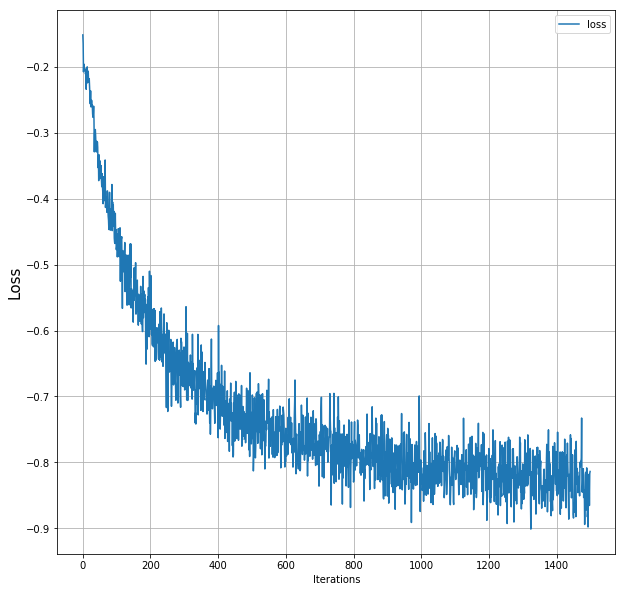

In [9]:
plot_loss(train_pipeline.v('loss_history'), ['loss'])

As we can see, loss starts to plateau after just 90 minutes of training. Relatively high variance suggests that model can benefit from bigger batch size.

<a id='validation'></a>

# Validation

Now, we want to check performance of our model on unseen part of the cubes. 

In [10]:
# Validation pipeline: no augmentations
val_template = (Pipeline()
                # Import model
                .import_model('ED', train_pipeline)
                # Load data/masks
                .load_component(src=[D('geometries'), D('labels')],
                                dst=['geometries', 'labels'])
                .crop(points=L(D('test_sampler'), NUM_CROPS), shape=CROP_SHAPE)
                .load_cubes(dst='images')
                .create_masks(dst='masks')
                .rotate_axes(src=['images', 'masks'])
                .scale(mode='normalize', src='images')
                # Predict with model
                .add_axis(src='masks', dst='masks')
                .predict_model('ED', 
                               fetches='predictions',
                               images=B('images'),
                               save_to=B('predictions'))
                )
val_pipeline = val_template << ds

In [11]:
batch = val_pipeline.next_batch(3, n_epochs=None)

We can just plot images of crops, hand-labeled masks and model predictions:

Images from P_cube


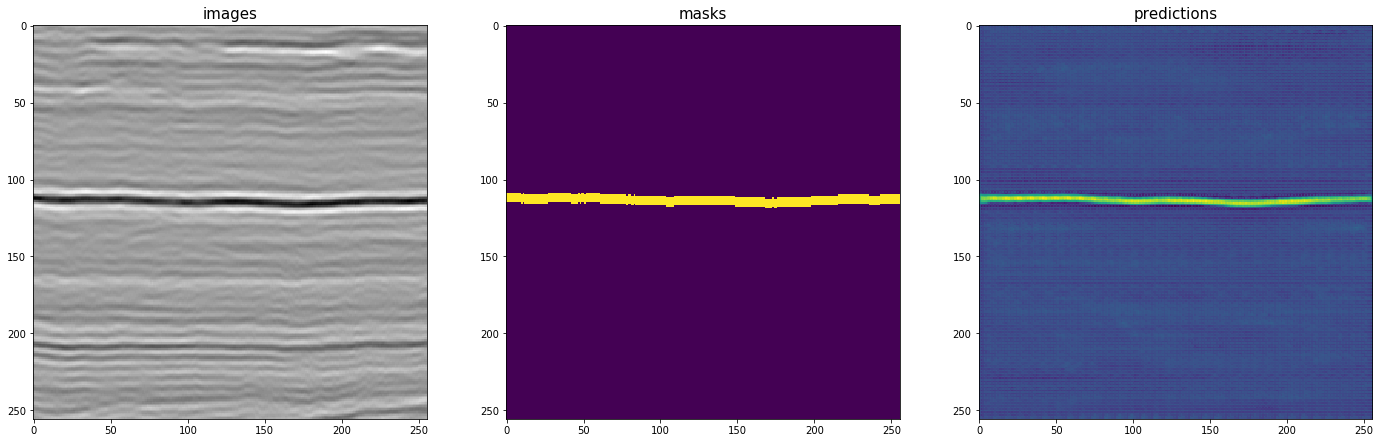

In [12]:
batch.plot_components(1, 'images', 'masks', 'predictions', overlap=False)

It is time to save the model:

In [13]:
model_save_dir = '/notebooks/SEISMIC_DATA/SAVED/MODELS/ED_DEMO'
train_pipeline.save_model_now('ED', model_save_dir)

It is way easier to analyse results when multiple crops are aggregated back into bigger picture. Method `make_grid`, paired with action `assemble_crops`, does exactly that:

In [14]:
load_config = {'load/path': model_save_dir}

# Pipeline template. Can be used multiple times (for different datasets)
val_template = (Pipeline()
                # Initialize everything
                .init_variable('result_images', init_on_each_run=list())
                .init_variable('result_preds', init_on_each_run=list())
                .init_model('dynamic', TFModel, 'loaded_model', load_config)              
                # Load data
                .load_component(src=D('geometries'), dst='geometries')
                .crop(points=L(D('grid_gen')),
                      shape=CROP_SHAPE)
                .load_cubes(dst='images')
                .rotate_axes(src='images')
                .scale(mode='normalize', src='images')
                # Predict with model, then aggregate
                .predict_model('loaded_model', 
                               fetches=['images', 'predictions'],
                               images=B('images'),
                               save_to=[V('result_images', mode='e'),
                                        V('result_preds', mode='e')])
                .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                  grid_info=D('grid_info'))
                .assemble_crops(src=V('result_images'), dst='assembled_img',
                                  grid_info=D('grid_info'))
                )

In [15]:
%%time
ds = ds.make_grid(ds.indices[0], CROP_SHAPE, 
                  [2201, 2202], [0, 800], [100, 1300],
                  strides=[2, 128, 128])

val_pipeline = val_template << ds

for _ in range(ds.grid_iters):
    batch = val_pipeline.next_batch(D('size'), n_epochs=None)

INFO:tensorflow:Restoring parameters from /notebooks/SEISMIC_DATA/SAVED/MODELS/ED_DEMO/model-1500
CPU times: user 15.4 s, sys: 1.82 s, total: 17.2 s
Wall time: 17.4 s


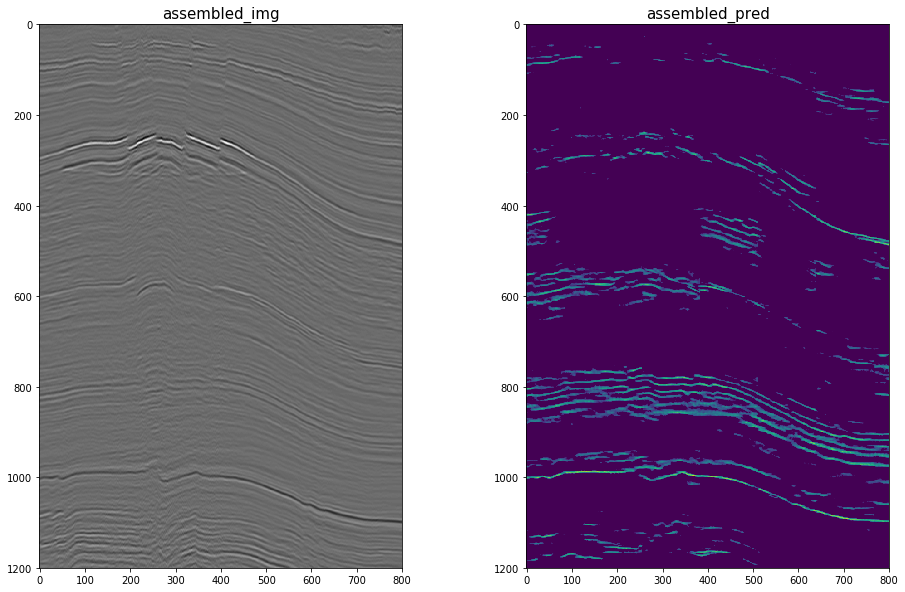

In [16]:
batch.plot_components(None, 'assembled_img', 'assembled_pred', rotate_axes=1, overlap=False)

Note that `assemble_crops` takes action only once, when all of the crops are passed through the model. Also, this function can be quite memory intensive.

Due to slow changes in data along ilines in any given cube, it might be a good idea to test our model against completely new cube. To begin with, we need to load it:

In [17]:
%%time
test_path_data = '/notebooks/SEISMIC_DATA/CUBE_2/M_cube.hdf5'

test_dsi = FilesIndex(path=[test_path_data], no_ext=True)
test_ds = SeismicCubeset(test_dsi)

test_ds = test_ds.load()

CPU times: user 2.74 s, sys: 284 ms, total: 3.03 s
Wall time: 3.17 s


In [18]:
%%time
test_ds = test_ds.make_grid(test_ds.indices[0], CROP_SHAPE, 
                            [201, 202], [0, 800], [100, 1300],
                            strides=[2, 128, 128])

val_pipeline = val_template << test_ds

for _ in range(test_ds.grid_iters):
    batch = val_pipeline.next_batch(D('size'), n_epochs=None)

INFO:tensorflow:Restoring parameters from /notebooks/SEISMIC_DATA/SAVED/MODELS/ED_DEMO/model-1500
CPU times: user 12.2 s, sys: 1.48 s, total: 13.7 s
Wall time: 13.4 s


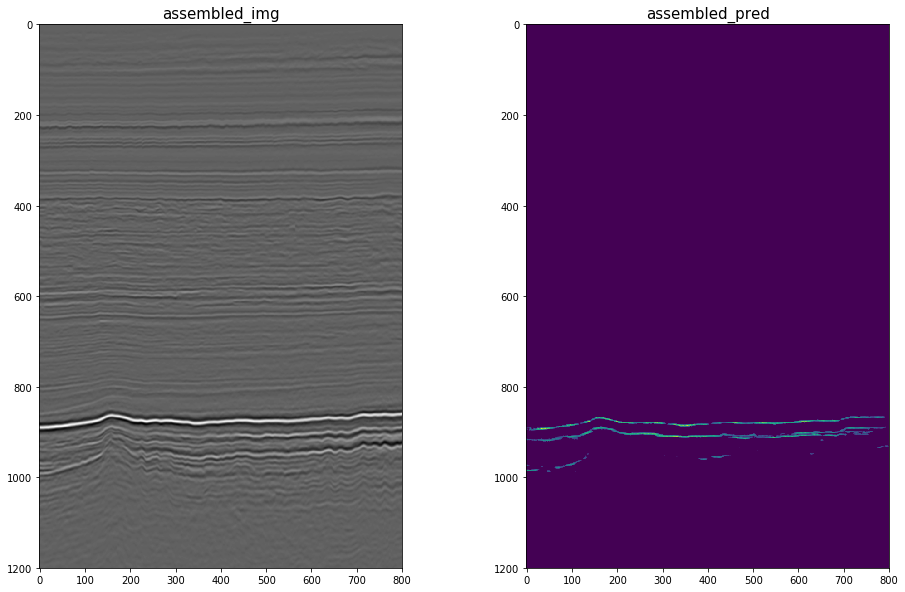

In [19]:
batch.plot_components(None, 'assembled_img', 'assembled_pred', rotate_axes=1, overlap=False)

As we can see, even on completely new cube our model outputs reasonable horizonts.

Currently, our prediction is essentially an image. In order to compare it with the ground truth, we need to convert it into the same format. That is what `get_point_cloud` function is for: it allows to pick only the highlighted parts of the image as separate horizons.

In [20]:
%%time
_ = test_ds.get_point_cloud(batch.assembled_pred, 'horizons', coordinates='lines', threshold=0.05)

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 122 ms


Finally, we can compare model detected horizon to the human-labeled: important metrics are mean/std value of difference and area of horizon with less than 5ms error.

**Note:** in the following output `FIRST` stands for the predicted horizon, while `SECOND` denotes the hand-labeled one.

First horizont length:                    795
Second horizont length:                   291449
Mean value/std of error:                  25.89609 / 3.561386
Number in 5 ms window:                    0
Rate in 5 ms window:                           0.0
Average height of FIRST horizont:         1004.848
Average height of SECOND horizont:        979.9523
In the FIRST, but not in the SECOND:      20
In the SECOND, but not in the FIRST:      290674





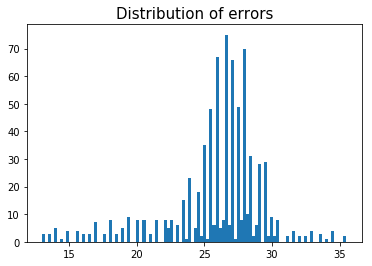

In [23]:
_ = test_ds.compare_to_labels(test_ds.horizons[0], cube_idx=0)

It is ill-advised to use model to predict on entire seismic cube. To overcome this, we've prepared quite a few of useful [scripts](./../scripts/): one for horizon picking, and one for computing all the metrics presented above.

<a id='criticism'></a>

# Criticism

The task in hand is ill-defined: it is very unclear, which horizons on the slide we want to get, how many of them, with which rules of picking. Current labels are quite inconsistent: they have different phase (some of them are on maximum values of amplitude, some of them at minimums); they separate different objects: most of them are following the brightest line on the slide, some of them are between crucial seismic facies, few of them track fissures. Most of them are made by automatic autocorellation and not really interesting (nor hard).

Despite that, this model serves as a great trampoline for the others: [horizont extension](./Horizons_extension.ipynb) and [facies segmentation](./Segmenting_interlayers.ipynb).

<a id='conclusion'></a>

# Conclusion

This notebook shows how to build a fully convolutional neural network in order to predict locations of seismic horizons. Dataset, processing pipeline and model training procedure are presented.

In exactly the same manner we trained models on shrinked datasets:  we trained one model on each individual cube, using every 200-th iline as the only training data (totalling in no more that 15 slides as a trainset). Unsurprisingly, neural network is able to recover horizons quite well on the rest of the cube: that is due to the fact that cube is changing slowly along its directions. Again, key metrics are area of detected horizon (compared to the hand-labeled one), mean difference between horizons, area of detected horizon that is closer than 5ms to the ground truth:

| Train/test cube |   Area, % | Mean error, ms | Area in 5ms window, % |
| :------ | ----: | ----: | ----: |
| CUBE_1 | 74, 74, 71  | 1.5, 2.1, 4.4 | 96, 94, 85 |
| CUBE_3 | 92, 92, 92  | 1.8, 1.9, 2.5 | 99.8, 99.5, 91.6 | 
| CUBE_VU_ONGMK |  73, 83, 84 | 3, 3.6, 4.3 | 89, 86, 84 |

Results in the table are consistent with our observations: detected horizonts are detected well, and the main point of improvement lies in enlarging the covered area. The only thing that catches the eye is suspiciously low area of detected horizons on `Cube_1`. Returning to the dataset [description](./../datasets/Horizonts_modelling.ipynb), we can easily identify the roots of the problem: hand-labeled horizons are for some reasons present in the zero-traces, and that skews our results.

Models, trained only on one cube, hardly works on the others: it just can'd adjust to the altering of values in the traces. Thus, we need to train model on at least multiple cubes in order to generalize on the others. 

Having 3 cubes in total, we trained models for each pair of them and used it as predictor on the remaining one: results (with the same metrics as before) are shown in the table:

| NOT in the training |   Area, % | Mean error, ms | Area in 5ms window, % |
| :------ | ----: | ----: | ----: |
| CUBE_1 | 5  | 0.85 | 94 |
| CUBE_3 | 45  | 1 | 97 | 
| CUBE_VU_ONGMK |  25 | 50 | 0 |

Again, results are not surprising: where test-cube structure resembles the train ones, model can follow the horizon quite well, with the easiest cube being labeled the best. It is the covered area that is the problem: different types of inner noises does not allow model to generalize well enough on big distances. The hardest cube (`Cube_VU_ONGMK`) stays pretty much unlabeled due to its unique hardness.

Overall, we can see that getting more data is of utmost importance: it helps to generalize better on unseen cubes in order to cover bigger area with predictions. Despite that, even this simple model, trained on just a few cubes, performs reasonably well and can be further improved by using deeper architecture and finer choice of hyper-parameters.

<a id='suggestions'></a>

# Suggestions for improvements

Thorough research of crop shape influence is needed: it is unknown which crop shape is the best, how dynamic shape changes model performance etc.

Also, this model can be used to get more train data for the others: for example, we can use it to predict somewhat continious horizons and fed it to `extension` model.